## Proyecto del Día 13 - Juego de Navegación en un Laberinto

Este proyecto tiene como objetivo desarrollar un entorno de laberinto simple y aplicar un algoritmo de **Aprendizaje por Refuerzo** para enseñar a una IA a navegar desde un punto inicial hasta un objetivo.

Dada la naturaleza de este proyecto, considero que el algoritmo más adecuado para este tipo de probleas es **Q-Learning**, por su facilidad de implelentación y comprensión, su estabilidad y su relación entre la exploración y la explotación.

Por esa razón te propongo resolverlo usando ese algoritmo, aunque dejo a tu criterio si quieres resolverlo con otro algoritmo de tu elección. Siempre estaré a favor de que investigues, y expandas las habilidades propuestas por tu cuenta.

### Descripción del Laberinto:

El laberinto se representa como una matriz de dos dimensiones, donde cada elemento puede ser:
+ un camino libre (0)
+ un obstáculo (1)
+ el objetivo (G)

La tarea es desarrollar un agente que pueda aprender a encontrar el camino desde un punto de inicio hasta el objetivo evitando obstáculos.


### Creación del Laberinto

Debido a que el desafío de hoy es bastante complejo, y que el objetivo final no se trata de que sepas desarrollar laberintos, sino sistemas para resolverlos, voy a facilitar la tarea entregando en este cuaderno el código para generar nuestros laberintos.

Tu parte será la siguiente, que es diseñar y entrenar un modelo de Q-Learning para resolver el laberinto de la manera mpas eficiente, y luego mostrar una visualización sobre cómo lo ha hecho.

Te deseo toda la suerte del mundo, y sobre todo, que te diviertas de a montones.

In [1]:
# Librerías necesarias para todo el ejercicio
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Función para crear el laberinto
def crear_laberinto(tamanio, porcentaje_paredes=20, inicio=(0, 0), meta=None):
    laberinto = np.zeros((tamanio, tamanio)) #inicializo laberinto en con ceros
    numero_paredes = int((tamanio * tamanio) * porcentaje_paredes / 100) #determino la cantidad de paredes que habran
    
    # Ubicar paredes
    for pared in range(numero_paredes):
        x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
        
        # Cuidar que inicio y meta no sean paredes
        if (x, y) != inicio and (meta is None or (x, y) != meta):
            laberinto[x, y] = 1
            
    # Ubicar la meta
    if meta:
        laberinto[meta] = 9  # Representa la meta con 9
    else:
        # Ubicar la meta aleatoriamente si no está especificado
        while True:
            x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
            if laberinto[x, y] == 0 and (x, y) != inicio:
                laberinto[x, y] = 9
                break
    
    return laberinto

In [3]:
# Función para visualizar el laberinto
def ver_laberinto(laberinto):
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    plt.colorbar();

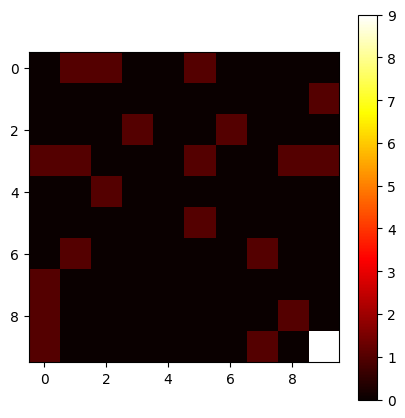

In [4]:
# Ejemplo de crear y mostrar laberintos
laberinto = crear_laberinto(10, 20, inicio=(0, 0), meta=(9, 9))
ver_laberinto(laberinto)

### Ahora te toca a ti

Lo que sigue es implementar todo el código para que un algoritmo de Q-Learning encuentre la manera más eficiente de llegar a la meta. Voy a dejarte los pasos que considero que son los necesarios para lograrlo

##### 1. Parámetros para el algoritmo Q-Learning

In [5]:
dimensiones = (laberinto.shape[0], laberinto.shape[1])
estado_inicial = (0,0)
movimientos = [(0,1),(0,-1),(1,0),(-1,0)] #Derecha, Izquierda, Abajo, Arriba
num_estados = dimensiones[0] * dimensiones[1]
num_acciones = len(movimientos)
estado_final = ()
obstaculos = []
for i in range(len(laberinto)):
    for j in range(len(laberinto[i])):
        if laberinto[i][j] == 9:
            estado_final = (i,j)
        if laberinto[i][j] == 1:
            obstaculos.append((i,j))

Q = np.zeros((num_estados, num_acciones))
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


##### 2. Función para elegir acciones equilibrando entre explotación y exploración

In [6]:
alpha = 0.1
gamma = 0.9
epsilon = 0.2
episodios = 100

def estado_a_indice(estado):
    return estado[0] * dimensiones[1] + estado[1]

def elegir_accion(estado):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(num_acciones))
    else:
        return np.argmax(Q[estado_a_indice(estado)])

##### 3. Función para simular la acción en el laberinto

In [12]:
def aplicar_accion(estado, accion_idx):
    accion = movimientos[accion_idx]
    nuevo_estado = tuple(np.add(estado, accion) % dimensiones)

    if nuevo_estado == obstaculos or nuevo_estado == estado:
        return estado, -100, False

    if nuevo_estado == estado_final:
        return nuevo_estado, 100, True
    
    return nuevo_estado, -1, False

##### 4. Función principal para ejecutar el algoritmo Q-Learning

In [13]:
for episodio in range(episodios):
    estado = estado_inicial
    terminado = False

    while not terminado:
        idx_estado = estado_a_indice(estado)
        accion_idx = elegir_accion(estado)
        nuevo_estado, recompensa, terminado = aplicar_accion(estado, accion_idx)
        idx_nuevo_estado = estado_a_indice(nuevo_estado)

        Q[idx_estado, accion_idx] = Q[idx_estado, accion_idx] + alpha * (recompensa + gamma * np.max(Q[idx_nuevo_estado]) - Q[idx_estado, accion_idx])
        
        estado = nuevo_estado

##### 5. Función para convertir coordenadas a índice lineal

In [15]:
politica = np.zeros(dimensiones, dtype=int)
politica

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

##### 6. Iniciar el laberinto y configurar el algoritmo Q-Learning

In [17]:
for i in range(dimensiones[0]):
    for j in range(dimensiones[1]):
        estado = (i,j)
        idx_estado = estado_a_indice(estado)
        mejor_accion = np.argmax(Q[idx_estado])
        politica[i, j] = mejor_accion

##### 7. Función para mostrar el aprendizaje del agente

In [18]:
print("Política aprendida (0: arriba, 1: abajo, 2: izquierda, 3: derecha)")
print(politica)

Política aprendida (0: arriba, 1: abajo, 2: izquierda, 3: derecha)
[[3 1 2 0 3 0 3 3 3 3]
 [3 0 0 3 0 0 3 1 1 0]
 [2 1 1 3 1 2 2 3 0 0]
 [3 0 1 1 1 1 1 1 0 0]
 [0 0 0 2 0 0 0 0 3 0]
 [2 0 0 2 3 0 0 3 0 0]
 [3 2 0 2 3 0 3 1 1 0]
 [2 2 0 3 2 1 0 0 0 3]
 [1 3 0 0 2 0 2 0 0 2]
 [1 1 1 1 3 1 3 2 0 0]]


##### 8. Visualizar el resultado